# Solutions for Lab Sheet 8 (COM3502-4502-6502 Speech Processing)

This lab sheet (solution) is part of the lecture COM[3502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level3/com3502.html "Open web page for COM3502 module")-[4502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level4/com4502.html "Open web page for COM4502 module")-[6502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/msc/com6502.html "Open web page for COM4502 module") Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), Dept. of [Computer Science](https://www.sheffield.ac.uk/dcs "Open web page of Department of Computer Science, University of Sheffield").

It is probably easiest to open this Jupyter Notebook with [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true "Open in Google Colab") since GitHub's Viewer does not always show all details correctly. <a href="https://colab.research.google.com/github/sap-shef/SpeechProcesssingLab/blob/main/Lab-Sheet-Solutions/Lab-Sheet-8-Solution.ipynb"><img align="right" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Notebook in Google Colab" title="Open and Execute the Notebook directly in Google Colaboratory"></a>

Please put questions, comments and correction suggestions in the [Blackboard](https://vle.shef.ac.uk) discussion board or send an email to [s.goetze@sheffield.ac.uk](mailto:s.goetze@sheffield.ac.uk).

In [1]:
# Let's do the ususal necessary and nice-to-have imports
%matplotlib inline
import matplotlib.pyplot as plt  # plotting
import seaborn as sns; sns.set() # styling ((un-)comment if you want)
import numpy as np               # math

# imports we need in addition for this lab sheet
from IPython import display as ipd  # to listen to audio
#import scipy.signal as sig          # for PSD calculation
import soundfile as sf              # to load WAVE files

## Loading Speech and Noise - Task 1

Load two WAVE files containing speech and noise, e.g. `speech_8kHz_murder.wav` and `noise_8kHz.wav` from the Internet address `https://staffwww.dcs.shef.ac.uk/people/S.Goetze/sound/` and load them into two variables `s` and `n`.

In [2]:
# download speech and noise example files
s_file_name = 'speech_8kHz_murder.wav'
!curl https://staffwww.dcs.shef.ac.uk/people/S.Goetze/sound/{s_file_name} -o {s_file_name} 
    
n_file_name = 'noise_8kHz.wav'
!curl https://staffwww.dcs.shef.ac.uk/people/S.Goetze/sound/{n_file_name} -o {n_file_name} 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  328k  100  328k    0     0  9691k      0 --:--:-- --:--:-- --:--:-- 9965k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 57808  100 57808    0     0  2677k      0 --:--:-- --:--:-- --:--:-- 2822k


In [3]:
# load speech wave into variable
s, sr_s = sf.read(s_file_name)

# load noise wave into variable
n, sr_n = sf.read(n_file_name)

Visualise the speech signal $s[k]$ and the noise signal $n[k]$.

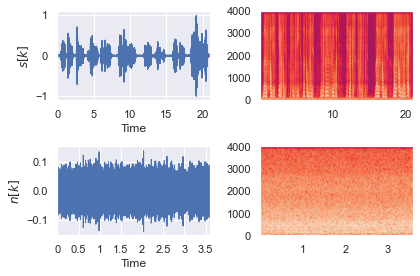

In [4]:
import librosa.display

# Plot audio and noise
plt.subplot(2,2,1)
librosa.display.waveplot(s, sr=sr_s)
plt.ylabel('$s[k]$')
plt.subplot(2,2,3)
librosa.display.waveplot(n, sr=sr_n)
plt.ylabel('$n[k]$');
plt.subplot(2,2,2)
plt.specgram(s, Fs=sr_s);
plt.grid(False)
plt.subplot(2,2,4)
plt.specgram(n, Fs=sr_n);
plt.grid(False)

plt.tight_layout()

In [5]:
ipd.Audio(s_file_name)

In [6]:
ipd.Audio(n_file_name)

Create a microphone signal $y[k] = s[k]+n[k]$ and visualise it. Note that the vectors should be cut the same length if needed.

<img src="NRSingleChannelBasic-web.png" align="center"/>

(28882,)
(28882,)


Text(0, 0.5, '$y[k]$')

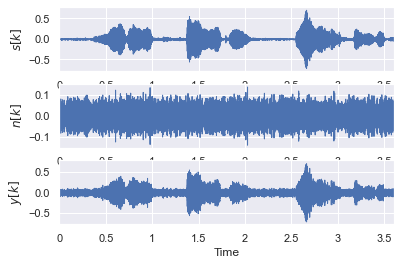

In [12]:
print(s.shape)
print(n.shape)

# cut to same lentgth
min_le = np.min([len(s),len(n)])
s=s[0:min_le]
n=n[0:min_le]

y=s+n

# Plot audio and noise
plt.subplot(3,1,1)
librosa.display.waveplot(s, sr=sr_s)
plt.ylabel('$s[k]$')
plt.subplot(3,1,2)
librosa.display.waveplot(n, sr=sr_s)
plt.ylabel('$n[k]$')
plt.subplot(3,1,3)
librosa.display.waveplot(y, sr=sr_s)
plt.ylabel('$y[k]$')

## Overlap Add

https://en.wikipedia.org/wiki/Overlap%E2%80%93add_method

## Adding Reverberation by convolving with Room Impulse Responses (RIRs) - Tasks 2

Room Impulse Responses (RIRs) charaterise rooms acoustically. They can be generated from the room geometry using the [Room Impulse Response Generator](https://www.audiolabs-erlangen.de/fau/professor/habets/software/rir-generator) which has to be installed using the `!pip install rir_generator` once and can then be imported. 

In [8]:
# uncomment the following line if you need to install
#!pip install rir_generator 
import rir_generator as rir

ModuleNotFoundError: No module named 'rir_generator'

It takes the room geometry by means of the room dimensions $L=[x,y,z]$ and the positions of one or more microphones and acoustic sources.

<img src="NR-MC_SignalModel-web.png" align="center"/>
<img src="NRSingleChannelBasic-web.png" align="center"/>



In [ ]:
# Audio RIR
h_audio = rir.generate(
      c=344,                  # Sound velocity (m/s)
      fs=fs,                  # Sample frequency (samples/s)
      r=[                     # Receiver position(s) [x y z] (m)
        [0.75,2.80,1.60],
        [0.75,2.80,1.60],
        [0.75,2.80,1.60],
        [0.75,2.80,1.60],
        [0.75,2.80,1.60],
        [0.75,2.80,1.60],
      ],
      s=[1.35,2.86,1.6],       # Source position [x y z] (m)
      L=[4, 6, 3],             # Room dimensions [x y z] (m)
      reverberation_time=0.4,  # Reverberation time (s)
      nsample=4096,            # Number of output samples
)
print(data_audio.shape)
print(h_audio.shape)
print('\n')

# Noise RIR
h_noise = rir.generate(
      c=340,                  # Sound velocity (m/s)
      fs=8000,                 # Sample frequency (samples/s)
      r=[                    # Receiver position(s) [x y z] (m)
        [0.75,2.80,1.60],
        [0.75,2.80,1.60],
        [0.75,2.80,1.60],
        [0.75,2.80,1.60],
        [0.75,2.80,1.60],
        [0.75,2.80,1.60],
      ],
      s=[2.00,4.20,1.60],        # Source position [x y z] (m)
      L=[4, 6, 3],           # Room dimensions [x y z] (m)
      reverberation_time=0.4,      # Reverberation time (s)
      nsample=4096,           # Number of output samples
)
print(data_noise.shape)
print(h_noise.shape)

In [ ]:
r = np.array([[1.75,2.80,1.60],
              [1.80,2.80,1.60],
              [1.85,2.80,1.60],
              [1.90,2.80,1.60],
              [1.95,2.80,1.60],
              [2.00,2.80,1.60],
              [2.05,2.80,1.60],
              [2.10,2.80,1.60]])

## Overlap-Add

In [ ]:
def nextPowerOf2(L):
    '''
    Calculates the smallest power of 2 which is bigger than input variable n
    
    This helper function can be used to calculate an appropriate 
    length for an DFT which is longer than the signal length n and a power of 2.
    
    Input:
        L: int
            signal length
    Output:
        p: integer which is greater or equal than n and a power of 2
    
    Examples:
        for L in range(20):
            print('nextPowerOf2(L) for L='+str(L)+' is '+str(nextPowerOf2(L)))
            
        x=ones(11)
        L_FFT=nextPowerOf2(len(x))
    '''
    if (L<2):
        return 2
    # If n is a power of 2 then return n 
    if (L and not(L & (L - 1))):
        return L
    # If n is NOT a power of 2 
    p = 1
    while (p < L) :
        p <<= 1 
    return p

def nextPowerOf2_simple(L):
    return int(np.max([2,2**np.ceil(np.log2(L))]))

In [ ]:
for L in range(20):
    print('nextPowerOf2(L) for L='+str(L)+' is '+str(nextPowerOf2(L))) 
    print('nextPowerOf2(L) for L='+str(L)+' is '+str(nextPowerOf2_simple(L)))


# Get smallest power of 2 at least as large as N
NFFT = 2 ** np.ceil(math.log2(N))

In [ ]:
L_x = 32
L_h = 4
x=np.ones(L_x)
h=np.ones(L_h)

L_Bl  = 8   # block length (see Fig 2.25 in https://staffwww.dcs.shef.ac.uk/people/S.Goetze/book/Ch2.S3.html)
L_hop = 8
L_DFT = nextPowerOf2(L_Bl+L_h-1)
# L_DFT = 16

noOfFrames = (L_x // L_hop) # number of blocks

# outer loop over mic channels
# h = np.zeros(L_DFT)
# h[:L_h] = h
H = np.fft.rfft(h, n=L_DFT)
oldBlock = []
for iFrame in range(noOfFrames):
    #x_block = np.zeros(L_DFT) # zero padding # not needed
    k = np.arange(iFrame*L_hop, iFrame*L_hop+L_Bl) # time vector
    x_block = x[k]
    # k = np.hstack((k,np.zeros(L_DFT-len(k))))  # zero padding
    X_block = np.fft.rfft(x_block, n=L_DFT)

    Y = X_block*H # frequency domain multiplication
    y = np.fft.irfft(Y, n=L_DFT)

    k2 = np.arange(iFrame*L_hop, iFrame*L_hop+L_DFT) # time vector
    plt.figure()
    plt.stem(k2,y)

## Copyright

This notebook is licensed to be used during the lecture COM[3502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level3/com3502.html "Open web page for COM3502 module")-[4502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level4/com4502.html "Open web page for COM4502 module")-[6502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/msc/com6502.html "Open web page for COM4502 module") Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), Dept. of [Computer Science](https://www.sheffield.ac.uk/dcs "Open web page of Department of Computer Science, University of Sheffield"). Any further use (beyond use for the lecture) is only permitted if agreed with the [module lead](mailto:s.goetze@sheffield.ac.uk). 